In [305]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import glob
import gzip
import fileinput
import time
import datetime
from scipy import stats

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

In [293]:
def get_chrom_sizes():
    chromSizefile = '/home/ampend/links/kidd-lab/www-mirror/www/track-hub/canFam3/canFam3.1-browser-chrom-sizes.fai'
    print ('Reading in chromosome lengths from: ', chromSizefile)
    chromSizeFile = open(chromSizefile, 'r')

    chromSizeList,chromlist = {},[]
    #I also need a list of chr and position for finding the index for windows 
    for line in chromSizeFile:
        if "chrUn" in line: #ignore chromsome unknowns 
            continue
        if "chrM" in line: #ignore mito
            continue

        line = line.rstrip()
        line = line.split()

        chromID = line[0] #chromosome ID
        chromlist.append(chromID)
        chromLength = int(line[1]) #length of chromosome
        chromSizeList[chromID] = chromLength

    return chromSizeList, chromlist
#####################################################################################################

In [294]:
wkDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Simulations/'
hetDir = wkDir + 'Heterozygosity/'

#Getting chromosome sizes
chromSizeList,chromlist = get_chrom_sizes()

Reading in chromosome lengths from:  /home/ampend/links/kidd-lab/www-mirror/www/track-hub/canFam3/canFam3.1-browser-chrom-sizes.fai


In [295]:
#keeping track of what simulation rounds/chromosome numbers got merged together to create the 75 simulated genomes
# that went into the FST and XP-CLR simulation calculations 
fileDict = {}
filesToProcess = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/Simulations/XP-CLR_75Simulation_WholeGenomePairings.txt','r')

for line in filesToProcess:
    line=line.rstrip().split('\t')
    if 'Genome' in line[0]: #skips header
        continue
    genomeNum, chromosome, simNum = int(line[0]),line[1],line[2]
    if genomeNum in fileDict:
        fileDict[genomeNum].append([chromosome,simNum])
    else:
        fileDict[genomeNum] = []
        fileDict[genomeNum].append([chromosome,simNum])
filesToProcess.close()
print('Added %i genome rounds of simulations to dictionary' % len(fileDict.keys()))



Added 75 genome rounds of simulations to dictionary


###############################################################################################

# Plotting the heterozygosity for all 75 simulated chromosomes and writing to outfiles

#########################################################################################################

In [400]:
inFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Heterozygosity/input/village_autos-X.snp.indel5.autoPar.vqsr99.FILTERED_biallelic.recode.frq.count_Hp'
fst_realHpList = []
fst_realHpCoord = []
for line in open(inFile,'r'):
    if 'CHROM' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    realHp = float(line[4])
    fst_realHpList.append(realHp)
    fst_realHpCoord.append([line[0],int(line[1]),int(line[2]),realHp])
print('%i real Hp window datapoints added...' % len(fst_realHpList))

44100 real Hp window datapoints added...


In [398]:
fst_simHpList = []
genomeCount = 0

for genomeNum in fileDict.keys(): #for each genome to process
    genomeCount += 1
    for i in range(0,len(fileDict[genomeNum])):
        chrom,simNum = fileDict[genomeNum][i][0],fileDict[genomeNum][i][1]
        inFile = hetDir + 'input/' + 'dog_thinned_%s.%s.simulation.frq.count_Hp' % (chrom,simNum)
        for line in open(inFile,'r'):
            if 'CHROM' in line: #skip header
                continue
            line=line.rstrip().split('\t')
            simHp = float(line[4])
            fst_simHpList.append(simHp)
print('%i simulated Hp window datapoints added...'%len(fst_simHpList))

16397780 simulated Hp window datapoints added...


In [414]:
#processing simulated data with pandas
df=pd.DataFrame(fst_simHpList)
df.columns = ['SimHp']
sim_pct99, sim_pct995, sim_pct999 = np.percentile(df['SimHp'], 99), np.percentile(df['SimHp'], 99.5), np.percentile(df['SimHp'], 99.9)
sim_pct1, sim_pct05, sim_pct01 = np.percentile(df['SimHp'], 1), np.percentile(df['SimHp'], .5), np.percentile(df['SimHp'], .1)
sim_pct025 = np.percentile(df['SimHp'], 0.25)
print('The simulated 1st percentile = ', sim_pct1)
print('The simulated 0.5th percentile = ', sim_pct05)
print('The simulated 0.25th percentile = ', sim_pct025)
print('The simulated 0.1st percentile = ', sim_pct01)

#processing the real data with pandas
real_df=pd.DataFrame(realHpList)
real_df.columns = ['RealHp']
real_pct99, real_pct995, real_pct999 = np.percentile(real_df['RealHp'], 99), np.percentile(real_df['RealHp'], 99.5), np.percentile(real_df['RealHp'], 99.9)
real_pct50 = np.percentile(real_df['RealHp'], 50)
real_pct1, real_pct05, real_pct01 = np.percentile(real_df['RealHp'], 1), np.percentile(real_df['RealHp'], .5), np.percentile(real_df['RealHp'], .1)
real_pct5 = np.percentile(real_df['RealHp'], 5)
print('\n\nThe real 50th percentile = ', real_pct50)
print('The real 5th percentile = ', real_pct5)
print('The real 1st percentile = ', real_pct1)
print('The real 0.5th percentile = ', real_pct05)

value = stats.percentileofscore(real_df['RealHp'], sim_pct05)
print('The percentile of the SIMULATED 0.5th percentile is equal to the following percentile in the REAL data: ', value)

value = stats.percentileofscore(real_df['RealHp'], sim_pct01)
print('The percentile of the SIMULATED 0.1st percentile is equal to the following percentile in the REAL data: ', value)

cutoff = stats.percentileofscore(df['SimHp'], real_pct5)
print('The 5th percentile of the REAL data is equal to the following percentile in the SIMULATED data: ', cutoff)
fst_sigThreshold = sim_pct025#real_pct5


The simulated 1st percentile =  0.175291196079
The simulated 0.5th percentile =  0.146045667083
The simulated 0.25th percentile =  0.121179238397
The simulated 0.1st percentile =  0.0947304289994


The real 50th percentile =  0.182122713877
The real 5th percentile =  0.0673336938886
The real 1st percentile =  0.0154573717723
The real 0.5th percentile =  0.0
The percentile of the SIMULATED 0.5th percentile is equal to the following percentile in the REAL data:  28.2358134288
The percentile of the SIMULATED 0.1st percentile is equal to the following percentile in the REAL data:  10.1944110135
The 5th percentile of the REAL data is equal to the following percentile in the SIMULATED data:  0.0306345853462


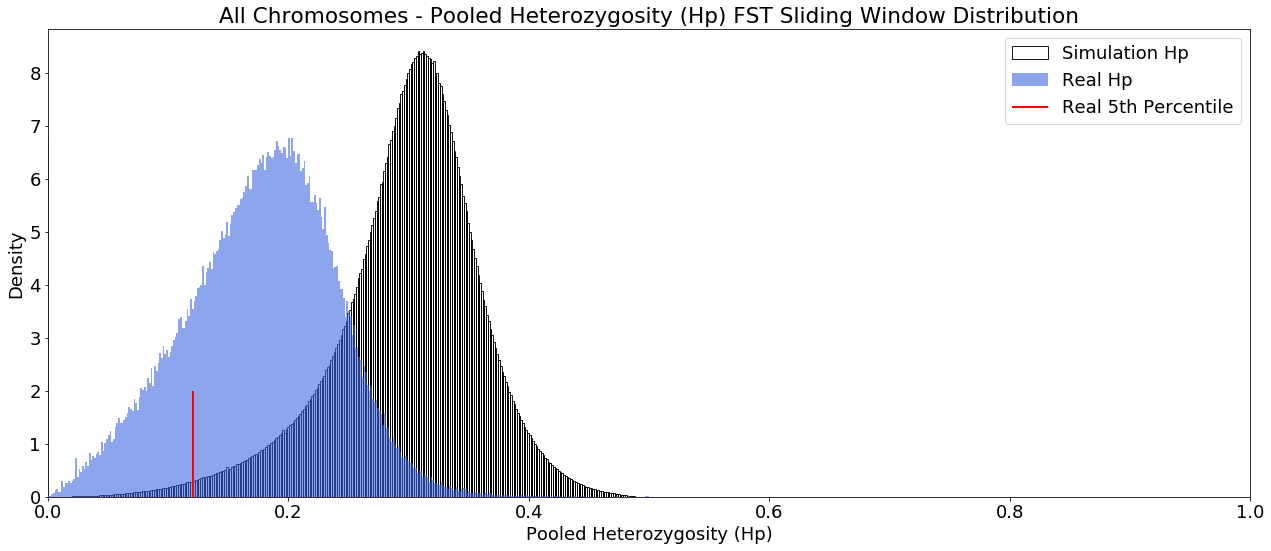

In [423]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 18}
plt.rc('font', **font)
#Plotting FST scores in REAL and SIMULATED 
fig = plt.figure(figsize=(18, 8)) #Set up subplots for below distributions
ax = fig.add_subplot(111)
_ = df['SimHp'].plot(kind='hist',label = 'Simulation Hp', bins=350,xlim=(0,1),alpha=0.9, normed = True,fill=False)
_ = real_df['RealHp'].plot(kind='hist',label = 'Real Hp', bins=350,xlim=(0,1),alpha=0.6, normed = True,color="royalblue")
ax.set_xlabel('Pooled Heterozygosity (Hp)')
ax.set_ylabel('Density')
ax.set_title('All Chromosomes - Pooled Heterozygosity (Hp) FST Sliding Window Distribution')
ax.vlines(x=fst_sigThreshold,ymin=0,ymax=2, lw=2,color="red",label='Real 5th Percentile')
#ax.vlines(x=sigThreshold,ymin=2,ymax=4, lw=2,color="green",label='Real 0.1st Percentile')

plt.legend()
plt.tight_layout()
#plotFile = real_finalResultsDir + 'Histogram_Real_vs_Simulated_FstValues.png'
#plt.savefig(plotFile) #save


###############################################################################################

# Obtaining the real Hp data from OUR Fst analysis 

In [408]:
real_fstFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/results/SummaryTable_PrimaryCDRs_Genes_Axelsson_CaganBlass.txt'
real_fstCoord = []

for line in open(real_fstFile,'r'):
    line=line.rstrip().split('\t')
    chrom,start,end,ID = line[0],int(line[1]),int(line[2]),line[3]
    ID = ID.replace('CDR','FST')
    real_fstCoord.append([chrom,start,end,ID,'Average Hp from Real Data','PASS/FAIL'])
print('%i real FST windows added... ' % len(real_fstCoord))

31 real FST windows added... 


In [416]:
#Getting the HP for our real fst data
failCount, nonXwindows = 0, 0
for window in real_fstCoord:
    windowChrom, windowStart, windowEnd = window[0],int(window[1]),int(window[2])
    #can't look at chrX windows, because we have no simulation data there
    if 'chrX' in windowChrom:
        continue
    nonXwindows += 1
    
    hp_fstWindow = []
    for hpwindow in realHpCoord:
        hpWindowChrom, hpWindowStart, hpWindowEnd, Hp = hpwindow[0],int(hpwindow[1]),int(hpwindow[2]), float(hpwindow[3])
        if hpWindowChrom == windowChrom: #same chromosome
            if windowStart <= hpWindowStart and hpWindowEnd <= windowEnd:# and windowEnd <= hpWindowEnd:
                hp_fstWindow.append(Hp)
    avg_Hp = np.mean(hp_fstWindow)
    window[4] = avg_Hp
    if avg_Hp > fst_sigThreshold:
        window[5] = 'FAIL'
        failCount += 1
    else:
        window[5] = 'PASS'
    print(window)
failProp = round((float(failCount)/nonXwindows)*100, 3)
print('%i/%i (%f%%) windows fail from our FST analysis' % (failCount,nonXwindows,failProp)) 


['chr1', 2350000, 3250000, 'FST_1', 0.054188274558402159, 'PASS']
['chr1', 79800000, 80150000, 'FST_2', 0.032967244661640603, 'PASS']
['chr3', 18800000, 19050000, 'FST_3', 0.060485067409230424, 'PASS']
['chr4', 40800000, 41000000, 'FST_4', 0.045709475246533335, 'PASS']
['chr5', 3850000, 4250000, 'FST_5', 0.055466736530923683, 'PASS']
['chr6', 39900000, 40100000, 'FST_6', 0.029563686404216662, 'PASS']
['chr6', 40350000, 40600000, 'FST_7', 0.092265166169394355, 'PASS']
['chr6', 46800000, 47350000, 'FST_8', 0.070045609100392439, 'PASS']
['chr7', 5000000, 5300000, 'FST_9', 0.1125657007233857, 'PASS']
['chr9', 8950000, 9250000, 'FST_10', 0.15900631193772144, 'FAIL']
['chr9', 12600000, 12800000, 'FST_11', 0.12167471178151665, 'FAIL']
['chr9', 13150000, 13450000, 'FST_12', 0.11517628873613571, 'PASS']
['chr9', 13650000, 14000000, 'FST_13', 0.071047510910339395, 'PASS']
['chr9', 14150000, 14650000, 'FST_14', 0.081693153336562505, 'PASS']
['chr11', 52700000, 52900000, 'FST_15', 0.05694145755077

sim05 = 3/25 (12.000000%) windows fail from our FST analysis


sim01 = 9/25 (36.000000%) windows fail from our FST analysis



In [15]:
#########################################################################################################

# Obtaining the real Hp and real Fst data for Axelsson Fst analysis 

In [364]:
#Need to read ALL raw fst values per window into an array, so that we can find what the axelsson/CB loci have
#   as FST values using OUR data
realFstWindowFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows'
realFstWindowData = []

for line in open(realFstWindowFile,'r'):
    if 'CHROM' in line: #skips header
        continue
    line=line.rstrip().split('\t')
    chrom,start,end,fst = line[0],int(line[1]),int(line[2]),float(line[7])
    realFstWindowData.append([chrom,start,end,fst])
print('Stored %i of our windows FST data into array...' % len(realFstWindowData))

Stored 43983 of our windows FST data into array...


In [365]:
#storing everything
axCB_fstCoord = []

#saving axelsson coordinates
AxFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/Axelsson_CaganBlass/results/Axelsson_canfam3.1.bed_GeneTable.txt'
for line in open(AxFile,'r'):
    line=line.rstrip().split('\t')
    if 'Chrom' in line[0]: #skips header
        continue
    chrom,start,end,ID = line[0],int(line[1]),int(line[2]),line[3]
    axCB_fstCoord.append([chrom,start,end,ID,'Max Fst','Average Hp from our data','PASS/FAIL FROM HP'])

#saving Cagan/Blass coordinates
CBFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/Axelsson_CaganBlass/results/CaganBlass_canfam3.1.bed_GeneTable.txt'
for line in open(CBFile,'r'):
    line=line.rstrip().split('\t')
    if 'Chrom' in line[0]: #skips header
        continue
    chrom,start,end,ID = line[0],int(line[1]),int(line[2]),line[3]
    axCB_fstCoord.append([chrom,start,end,ID,'Max Fst','Average Hp from our data','PASS/FAIL FROM HP'])
print('%i Axelsson and Cagan/Blass FST windows added... ' % len(axCB_fstCoord))



54 Axelsson and Cagan/Blass FST windows added... 


In [417]:
#Now searching through each Axelsson/CB window for what the Hp and Fst would be 
failCount, nonXwindows = 0, 0
for window in axCB_fstCoord:
    windowChrom, windowStart, windowEnd, ID = window[0],int(window[1]),int(window[2]), window[3]
    if 'chrX' in windowChrom: #we dont have simulation data for the X
        continue
    nonXwindows += 1
    #print(window)
    ###What is HP for this window???
    hp_fstWindow = []
    for hpwindow in realHpCoord:
        hpWindowChrom, hpWindowStart, hpWindowEnd, Hp = hpwindow[0],int(hpwindow[1]),int(hpwindow[2]), float(hpwindow[3])
        if hpWindowChrom == windowChrom: #same chromosome
            windowStartDiff = abs(hpWindowStart-windowStart)
            windowEndDiff = abs(hpWindowEnd-windowEnd)
            #print(windowStartDiff,windowEndDiff)
            #if windowStart <= hpWindowStart:# and hpWindowEnd <= windowEnd:# and windowEnd <= hpWindowEnd:
            if windowStartDiff < 50000 or windowEndDiff <50000:
                #print(windowStartDiff,windowEndDiff)
                #print(hpwindow)
                hp_fstWindow.append(Hp)
    avg_Hp = np.mean(hp_fstWindow)
    window[5] = avg_Hp
    #print(len(hp_fstWindow))
    if avg_Hp > fst_sigThreshold:
        window[6] = 'FAIL'
        failCount += 1
    else:
        window[6] = 'PASS'
    print(window)
    #break
failProp = round((float(failCount)/nonXwindows)*100, 3)
print('%i/%i (%f%%) windows fail from our Axelsson and cagan/blass analysis' % (failCount,nonXwindows,failProp)) 



['chr1', 2515609, 3315787, 'AX_1', 'Max Fst', 0.072974552396495002, 'PASS']
['chr4', 40803259, 41001116, 'AX_10', 'Max Fst', 0.066869529499414992, 'PASS']
['chr6', 24980113, 25280253, 'AX_11', 'Max Fst', 0.080793362840254998, 'PASS']
['chr6', 46854109, 47454177, 'AX_12', 'Max Fst', 0.16240891922950002, 'FAIL']
['chr6', 53253174, 53453184, 'AX_13', 'Max Fst', 0.059090776833895006, 'PASS']
['chr7', 24632212, 25033464, 'AX_14', 'Max Fst', 0.16366644480028997, 'FAIL']
['chr8', 27696699, 27896700, 'AX_15', 'Max Fst', 0.15218063857838998, 'FAIL']
['chr10', 2714704, 2914705, 'AX_16', 'Max Fst', 0.14385182376746, 'FAIL']
['chr10', 3615192, 4015195, 'AX_17', 'Max Fst', 0.050533193247899996, 'PASS']
['chr11', 47269655, 47669725, 'AX_19', 'Max Fst', 0.16724644668056501, 'FAIL']
['chr1', 46572801, 46874590, 'AX_2', 'Max Fst', 0.14019297533692499, 'FAIL']
['chr14', 7244540, 7543124, 'AX_20', 'Max Fst', 0.15465136983756997, 'FAIL']
['chr15', 5093547, 5393613, 'AX_21', 'Max Fst', 0.069107678469399997

sim01 = 18/35 (51.429000%) windows fail from our Axelsson and cagan/blass analysis


#########################################################################################################
#########################################################################################################
#########################################################################################################

# Processing the REAL and simulated XP-CLR window sizes

In [420]:
inFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Heterozygosity/input/village_autos-X.snp.indel5.autoPar.vqsr99.FILTERED_biallelic.recode.frq.count_XPCLR_Hp'
xpclr_realHpList = []
xpclr_realHpCoord = []
for line in open(inFile,'r'):
    if 'CHROM' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    realHp = float(line[4])
    xpclr_realHpList.append(realHp)
    xpclr_realHpCoord.append([line[0],int(line[1]),int(line[2]),realHp])
print('%i real Hp window datapoints added...' % len(xpclr_realHpList))


220957 real Hp window datapoints added...


In [421]:
xpclr_simHpList = []
genomeCount = 0

for genomeNum in fileDict.keys(): #for each genome to process
    for i in range(0,len(fileDict[genomeNum])):
        chrom,simNum = fileDict[genomeNum][i][0],fileDict[genomeNum][i][1]
        inFile = hetDir + 'input/' + 'dog_thinned_%s.%s.simulation.frq.count_XPCLRWindowSizes_Hp' % (chrom,simNum)
        for line in open(inFile,'r'):
            if 'CHROM' in line: #skip header
                continue
            line=line.rstrip().split('\t')
            simHp = float(line[4])
            xpclr_simHpList.append(simHp)
print('%i simulated Hp window datapoints added...'%len(xpclr_simHpList))


16397780 simulated Hp window datapoints added...


In [424]:
#processing simulated data with pandas
df=pd.DataFrame(xpclr_simHpList)
df.columns = ['SimHp']
sim_pct99, sim_pct995, sim_pct999 = np.percentile(df['SimHp'], 99), np.percentile(df['SimHp'], 99.5), np.percentile(df['SimHp'], 99.9)
sim_pct1, sim_pct05, sim_pct01 = np.percentile(df['SimHp'], 1), np.percentile(df['SimHp'], .5), np.percentile(df['SimHp'], .1)
sim_pct025 = np.percentile(df['SimHp'], 0.25)
print('The simulated 1st percentile = ', sim_pct1)
print('The simulated 0.5th percentile = ', sim_pct05)
print('The simulated 0.25th percentile = ', sim_pct025)
print('The simulated 0.1st percentile = ', sim_pct01)

#processing the real data with pandas
real_df=pd.DataFrame(xpclr_realHpList)
real_df.columns = ['RealHp']
real_pct99, real_pct995, real_pct999 = np.percentile(real_df['RealHp'], 99), np.percentile(real_df['RealHp'], 99.5), np.percentile(real_df['RealHp'], 99.9)
real_pct50 = np.percentile(real_df['RealHp'], 50)
real_pct5 = np.percentile(real_df['RealHp'], 5)
real_pct1, real_pct05, real_pct01 = np.percentile(real_df['RealHp'], 1), np.percentile(real_df['RealHp'], .5), np.percentile(real_df['RealHp'], .1)
print('\n\nThe real 50th percentile = ', real_pct50)
print('The real 5th percentile = ', real_pct5)
print('The real 1st percentile = ', real_pct1)
print('The real 0.5th percentile = ', real_pct05)


value = stats.percentileofscore(real_df['RealHp'], sim_pct05)
print('The percentile of the simulated 0.5th percentile is equal to the following percentile in the REAL data: ', value)

value = stats.percentileofscore(real_df['RealHp'], sim_pct01)
print('The percentile of the simulated 0.1st percentile is equal to the following percentile in the REAL data: ', value)

value = stats.percentileofscore(df['SimHp'], real_pct5)
print('The 5th percentile value in the REAL data is equal to the following percentile in the SIMULATED data: ', value)
xpclr_sigThreshold = sim_pct025


The simulated 1st percentile =  0.119923124067
The simulated 0.5th percentile =  0.0978727944159
The simulated 0.25th percentile =  0.0792687405271
The simulated 0.1st percentile =  0.0598113761861


The real 50th percentile =  0.180482686651
The real 5th percentile =  0.0628462600538
The real 1st percentile =  0.00631427283894
The real 0.5th percentile =  0.0
The percentile of the simulated 0.5th percentile is equal to the following percentile in the REAL data:  12.223871613
The percentile of the simulated 0.1st percentile is equal to the following percentile in the REAL data:  4.57600347579
The 5th percentile value in the REAL data is equal to the following percentile in the SIMULATED data:  0.116628592407


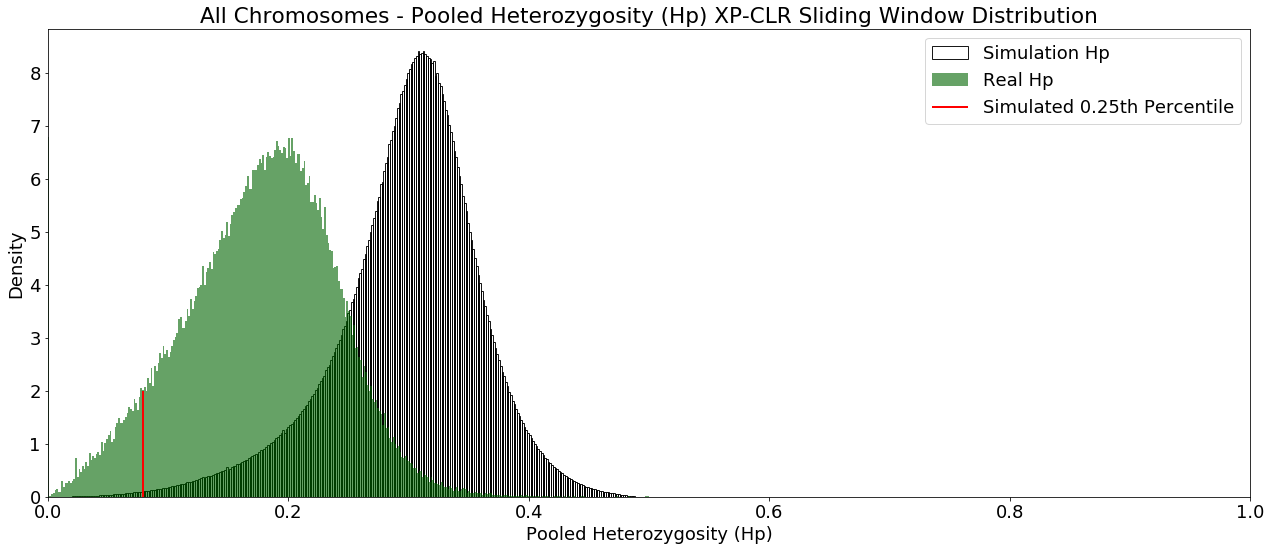

In [427]:
valfont = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 18}
plt.rc('font', **font)
#Plotting XP-CLR scores in REAL and SIMULATED 
fig = plt.figure(figsize=(18, 8)) #Set up subplots for below distributions
ax = fig.add_subplot(111)
_ = df['SimHp'].plot(kind='hist',label = 'Simulation Hp', bins=350,xlim=(0,1),alpha=0.9, normed = True,fill=False)
_ = real_df['RealHp'].plot(kind='hist',label = 'Real Hp', bins=350,xlim=(0,1),alpha=0.6, normed = True,color="darkgreen")
ax.set_xlabel('Pooled Heterozygosity (Hp)')
ax.set_ylabel('Density')
ax.set_title('All Chromosomes - Pooled Heterozygosity (Hp) XP-CLR Sliding Window Distribution')
#ax.vlines(x=xpclr_sim_pct01,ymin=0,ymax=2, lw=2,color="red",label='Simulated 0.1st Percentile')
#ax.vlines(x=sigThreshold,ymin=0,ymax=2, lw=2,color="blue",label='Simulated Percentile')
ax.vlines(x=xpclr_sigThreshold,ymin=0,ymax=2, lw=2,color="red",label='Simulated 0.25th Percentile')

plt.legend()
plt.tight_layout()
#plotFile = real_finalResultsDir + 'Histogram_Real_vs_Simulated_FstValues.png'
#plt.savefig(plotFile) #save


#########################################################################################################

#########################################################################################################

# Processing REAL XP-CLR Sweeps now - Filtering for HP  

In [495]:
real_xpclrFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/SummaryTable_XPCLR_Genes_CDR_Axelsson_CaganBlass.txt'
real_xpclrCoord = []
xpclrDict = {}

for line in open(real_xpclrFile,'r'):
    line=line.rstrip().split('\t')
    chrom,start,end,ID = line[0],int(line[1]),int(line[2]),line[3]
    ID = ID.replace('CDR','XP-CLR')
    real_xpclrCoord.append([chrom,start,end,ID,'Average Hp from Real Data','PASS/FAIL'])
    xpclrDict[ID] = []
    for i in range(0,11): #create empty
        xpclrDict[ID].append('')
    for i in range(0,len(line)):
        xpclrDict[ID][i] = line[i]
    
print('%i real XP-CLR windows added... ' % len(real_xpclrCoord))

#Making Ensembl gene intersect dictionary for XP-CLR hits to be parsed later
ensGDict = {} #keeping track of the EnsG/EnsP models for TopGO enrichment tests
intersectfile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/Intersect_With_Ensembl81Genes_50kbWindow.txt' 
ensGDict = parse_gene_intersect_file(ensGDict,intersectfile)


208 real XP-CLR windows added... 


In [497]:
#Getting the HP for our real XP-CLR data and seeing if they passed the Hp threshold
xpclrOutPath = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/'
new_real_xpclrFile = open(xpclrOutPath + 'SummaryTable_XPCLR_Genes_CDR_Axelsson_CaganBlass_PASSFAIL.txt','w')
sigGenes_PASSOnly = open(xpclrOutPath + 'TopGO_PassHpWindowsOnly_XP-CLR_SignificantGenes_50kbWindow.txt','w')

failCount, nonXwindows = 0, 0
for window in real_xpclrCoord:
    windowChrom, windowStart, windowEnd = window[0],int(window[1]),int(window[2])
    #can't look at chrX windows, because we have no simulation data there
    if 'chrX' in windowChrom:
        continue
    nonXwindows += 1
    hp_fstWindow = []
    
    ID = window[3]
    
    for hpwindow in realHpCoord:
        hpWindowChrom, hpWindowStart, hpWindowEnd, Hp = hpwindow[0],int(hpwindow[1]),int(hpwindow[2]), float(hpwindow[3])
        if hpWindowChrom == windowChrom: #same chromosome
            if windowStart <= hpWindowStart and hpWindowEnd <= windowEnd:# and windowEnd <= hpWindowEnd:
                hp_fstWindow.append(Hp)
    avg_Hp = np.mean(hp_fstWindow)
    window[4] = avg_Hp
    if avg_Hp > xpclr_sigThreshold:#xpclr_sim_pct01:
        window[5] = 'FAIL'
        failCount += 1
        xpclrDict[ID].append('FAIL')
        xpclrDict[ID].append(str(avg_Hp))
    else:
        window[5] = 'PASS'
        xpclrDict[ID].append('PASS')
        xpclrDict[ID].append(str(avg_Hp))
        if ID in ensGDict.keys():
            for i in ensGDict[ID]:
                sigGenes_PASSOnly.write(i + '\n')
    #break
failProp = round((float(failCount)/nonXwindows)*100, 3)
print('%i/%i (%f%%) windows fail from our XP-CLR analysis' % (failCount,nonXwindows,failProp)) 

for ID in xpclrDict:
    new_real_xpclrFile.write('\t'.join(xpclrDict[ID]) + '\n')
print('DONE') 
 
    
sigGenes_PASSOnly.close()
new_real_xpclrFile.close()

77/208 (37.019000%) windows fail from our XP-CLR analysis
DONE


sim01 = 124/208 (59.615000%) windows fail from our XP-cLR analysis

sim025 = 77/208 (37.019000%) windows fail from our XP-CLR analysis

sim05 = 42/208 (20.192000%) windows fail from our XP-CLR analysis

sim1 = 24/208 (11.538000%) windows fail from our XP-CLR analysis


###########################################################

Now make sense of the TopGO enrichment results....

###########################################################


In [474]:
def make_topgo_dict(totalTopGoFile):
    topGODict={}
    for line in open(totalTopGoFile,'r'):
        line=line.rstrip().split('\t')
        if 'GO:' not in line[1]:
            continue
        GOID = line[1]
        topGODict[GOID] = line
    print('%i enriched gene categories added to topGoDict' % len(topGODict))

    return topGODict
################################################################################################################
def make_merged_total_TopGOFile(mergedOutFile,topGoDir):
    outputs = ['PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_ParentChild_BP.txt','PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_ParentChild_MF.txt', 'PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_ParentChild_CC.txt']
    cmd = 'cat %s%s %s%s %s%s > %s' % (topGoDir,outputs[0],topGoDir,outputs[1],topGoDir,outputs[2],mergedOutFile)
    runCMD(cmd)
################################################################################################################
def get_full_BLASTGO_category_names():
    print ('#I downloaded ALL GO ontology categories from the geneontology.org website from the link:')
    print ('http://purl.obolibrary.org/obo/go.obo')
    b2goDir = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/'
    fullGONameDatabase = b2goDir + 'Full_GO_Ontology_Database.obo'
    nameDict = {}
    for line in open(fullGONameDatabase,'r'):
        line=line.rstrip()
        if 'id:' in line:
            line = line.replace('id: ','')
            GOID = line
            nameDict[GOID] = ''
        if 'name:' in line:
            line = line.replace('name: ','')
            goName = line
            nameDict[GOID] = goName
    print('%i GO categories added to full name dictionary' % len(nameDict.keys()))       
    return nameDict
################################################################################################################
def get_humanphenotypes():
    hpoFile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/Human-Phenotype-Ontology/HPO_Oct2017Release_genes-to-phenotypes.txt'
    hpoDict = {}
    for line in open(hpoFile,'r'):
        line=line.rstrip().split('\t')
        if '#' in line[0]: #skips header
            continue
        geneName, phenotype, HP = line[1], line[2], line[3]
        if geneName not in hpoDict.keys():
            hpoDict[geneName] = []
        hpoDict[geneName].append([phenotype, HP])    
    print('%i human phenotyped genes added to dictionary' % len(hpoDict))
    return hpoDict
################################################################################################################
def make_ens_transcript_map_dict():
    ensembl_MapFile = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/Insertion_Assessment/dog_Ensembl_EnsG_EnsP_EnsT_Map.txt'
    enDict = {}
    for line in open(ensembl_MapFile,'r'):
        line=line.rstrip().split()
        if '#' in line[0]: #skips header
            continue
        gene, enG, enT = line[1], line[2], line[0]
        enG = enG.split('.')[0]
        if enT not in enDict.keys():
            enDict[enG]=[gene, enT]
    print('%i genes added to enTDict' % len(enDict))
    return enDict
################################################################################################################
def make_xpclr_gene_dict():
    xpclrGeneDict = {}
    intFile =  '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/' + 'Intersect_With_Ensembl81Genes_50kbWindow.txt'
    for line in open(intFile,'r'):
        line=line.rstrip().split('\t')
        insertion = line[3]
        longgene = line[10].split('_')
        ensG = longgene[1]
        xpclrGeneDict[ensG] = insertion
    print('%i genes added to dictionary' % len(xpclrGeneDict.keys()))
    return(xpclrGeneDict)
################################################################################################################
geneTable = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_GeneTables_WithEnscafIDsAndChrom.txt'
#Saving gene-protein links that were processed with BLAST2GO to array
TotEnsGene = {}

for line in open(geneTable,'r'):
    line = line.rstrip().split()
    ensG,ensP,chrom,start,end,geneName = line[1],line[0],line[5],line[6],line[7],line[8]
    TotEnsGene[ensG] = [ensG,ensP,chrom,start,end,geneName]
print ('\n%i genes read into gene-protein ID array' % len(TotEnsGene))


19856 genes read into gene-protein ID array


In [475]:
topGoDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/TopGO/'
#Merge all the outputs into one to make dictionary
mergedOutFile = topGoDir + 'Total_PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_ParentChild_BP_CC_MF.txt'
make_merged_total_TopGOFile(mergedOutFile, topGoDir)
topGODict = make_topgo_dict(mergedOutFile)

#Define outfile to keep track of topGO annotations
annotationFile = open(topGoDir + 'PASSOnly_AnnotatedTopGO_EnrichedGenes_50kb_FinalXP-CLR_SimulationThreshold.txt','w')

insGeneGODict = {}
#Set-up inputs
nameDict = get_full_BLASTGO_category_names()
enDict = make_ens_transcript_map_dict()
hpoDict = get_humanphenotypes()
xpclrGeneDict = make_xpclr_gene_dict()

#Now begin processing
outputs = ['PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_BP_TopGOOutput_ParentChild_Genes.txt','PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_MF_TopGOOutput_ParentChild_Genes.txt','PASSOnly_FinalXP-CLR_50KbWindowIntersect_SimulationThreshold_EnrichmentTable_Pvalue=0.05_CC_TopGOOutput_ParentChild_Genes.txt']
for topGoGeneFile in outputs:
    topGoGeneFile = open(topGoDir + topGoGeneFile,'r')
    for line in topGoGeneFile:
        line=line.replace('"','')
        line=line.rstrip().split(' ')
        if 'GO:' not in line[0]: #skips headers
            continue
        GOID = line[0]
        geneLists = line[1]
        genes = geneLists.split(',')
        topGOInfo = topGODict[GOID]
        if GOID in nameDict.keys():
            topGOInfo[2] = nameDict[GOID]
        genomeCount, setCount, pvalue1,pvalue2 =  topGOInfo[3],topGOInfo[4],float(topGOInfo[8]),float(topGOInfo[9])
        for i in range(0,len(topGOInfo)):
            annotationFile.write('%s\t' % topGOInfo[i])
        #What genes are annotated for this GO category
        ensGList, insList, geneNames, count = [], [], [], 0
        uniqueInsertionList = [] #Clear to keep track of how many unique insertions are found for this category
        for gene in genes:
            ensG,engP = gene.split('|')[0],gene.split('|')[1]
            ensGList.append(ensG)
            #What insertions do these correspond to
            insertion = xpclrGeneDict[ensG]
            insList.append(insertion)
            geneName = TotEnsGene[ensG][5]
            geneNames.append(geneName)
            if insertion not in uniqueInsertionList:
                uniqueInsertionList.append(insertion)
        y = ", ".join(map(str, ensGList))
        annotationFile.write('%s\t' % (y))
        y = ", ".join(map(str, geneNames))
        annotationFile.write('%s\t' % (y))
        y = ", ".join(map(str, insList))
        annotationFile.write('%s\t' % (y))
        #Number of Unique insertions
        annotationFile.write('%i\n' % (len(uniqueInsertionList)))
annotationFile.close()

277 enriched gene categories added to topGoDict
#I downloaded ALL GO ontology categories from the geneontology.org website from the link:
http://purl.obolibrary.org/obo/go.obo
49395 GO categories added to full name dictionary
15548 genes added to enTDict
3682 human phenotyped genes added to dictionary
446 genes added to dictionary



#  Drawing XP-CLR Plots with Hp and Fst

In [556]:
#READING IN PER SITE FST DATA POINTS FOR PLOTTING IN SUBSEQUENT STEPS
#Saves all the per site Fst data into a dictionary for faster parsing
#Per Site, Total callset
perTotal = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/PerSite/Merged_VillageWolf_mxb_rm_PERSITE_54callset_AutoXParXNonPar_Hudson_Fst_PerSite_Zscores.txt'
perSiteDict, chroms, count = {}, [], 0

inFile = open(perTotal,'r')
for line in inFile:
    if 'Chrom' in line or 'CHROM' in line:
        continue
    line = line.rstrip().split('\t')
    chrom,start,end,fst,Z = line[0],int(line[1]),int(line[1]),float(line[2]),float(line[3])
    if chrom not in chroms:
        chroms.append(chrom)
        perSiteDict[chrom] = []
    perSiteDict[chrom].append([chrom,start,fst])
    count += 1
print('%i per site SNPs added to the perSiteDict' % count)

7315882 per site SNPs added to the perSiteDict


In [508]:
def read_xpclr_file(inFile):
    #For keeping track of data
    totalData, chroms = {}, []
    scores, passCount = [], 0
    totalGrids,infCounts,failed_SNPZero,failed_SNPMin = 0, 0, 0, 0

    for line in inFile:
        line=line.rstrip().split(' ')
        if 'chrom' in line[0]:#skips header
            continue
        chrom = 'chr' + line[0]
        if chrom not in chroms:
            chroms.append(chrom)
            totalData[chrom] = []
        #processing line for more data
        gridNum, snpCount = int(line[1]),int(line[2])
        physical_pos,genetic_pos,max_s = round(float(line[3])),float(line[4]),float(line[6])
        XPCLR_score = line[5]
        totalGrids+=1
        #keeping track of certain data points
        if 'inf' in XPCLR_score:
            infCounts+=1
            continue
        if snpCount < 1:
            failed_SNPZero += 1
            continue
        if snpCount < 5:
            failed_SNPMin += 1
            continue
        XPCLR_score=float(line[5])
        scores.append(XPCLR_score)
        totalData[chrom].append([chrom,gridNum,snpCount,physical_pos,genetic_pos,XPCLR_score,max_s])
        passCount += 1
    inFile.close()
    ################################################################
    print('%s grids were processed by XP-CLR' % ((totalGrids)))
    print('##EXCLUSIONS')
    print('%s of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)' % infCounts)
    print('%s of the grids had no SNPs and were removed' % failed_SNPZero)
    print('%s of the grids had fewer than 5 SNPs and were removed' % failed_SNPMin)
    print('##FOR PROCESSING')
    print('%s of the grids remained for further processing after passing filtrations' % passCount)
    
    return totalData
##############################################################################################



#GET the XP-CLR raw data
posFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/Merged_Dogs_v_Wolves_XPCLR_50kbWindow_2kbGrid.xpclr.txt','r')
totalData = read_xpclr_file(posFile)

1049761 grids were processed by XP-CLR
##EXCLUSIONS
801888 of the grids had scores equal to infinity and were excluded until we determine what that means (failure??)
43599 of the grids had no SNPs and were removed
69545 of the grids had fewer than 5 SNPs and were removed
##FOR PROCESSING
134729 of the grids remained for further processing after passing filtrations


In [511]:
#read in chromosome average files === saves time from running previous data cell
inFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/25kbSlidingWindowAverages_Dogs_v_Wolves_XP-CLR_50kbWindow_2kbGrid.txt','r')
sliding_window_coord_dict, chroms, count = {}, [], 0
slideData, noDataCount = [], 0

for line in inFile:
    if 'Average' in line: #skips header
        continue
    line=line.rstrip().split('\t')
    chrom=line[0]   
    if chrom not in chroms:
        chroms.append(chrom)
        sliding_window_coord_dict[chrom] = []
    chrom,start,end,windowcount,mean,median=line[0],int(line[1]),int(line[2]),int(line[3]),line[4],(line[5])
    sliding_window_coord_dict[chrom].append([chrom,start,end,windowcount,mean,median])
    #Remove windows that have 'na' as the mean (because there were no windows with snp/xpclr data there)
    if 'na' in line[4]:
        noDataCount += 1
        continue
    chrom,start,end,windowcount,mean,median=line[0],int(line[1]),int(line[2]),int(line[3]),float(line[4]),float(line[5])
    slideData.append([chrom,start,end,windowcount,mean,median])
    count += 1
print('%i sliding windows had no data and were therefore ignored...' % noDataCount)
print('%i windows remain for analysis and determination of significance thresholds\n' % len(slideData))


140967 sliding windows had no data and were therefore ignored...
79369 windows remain for analysis and determination of significance thresholds



In [560]:
def find_gene_pos():
    #GTF file with genes of interest:
    gtfFile = open('/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/ensembl_input/Canis_familiaris.CanFam3.1.81.gtf','r')
    #YOU NEED TO DO THIS BY HAND BY GREP'ING THE GTF FILE:
    genesOfInterest, genePos = [], []
    for line in gtfFile:
        if '#' in line:
            continue
        line=line.rstrip().split('\t')
        if 'exon' not in line[2]:
            continue
        chrom, start, end, direction = 'chr' + line[0], int(line[3]), int(line[4]), str(line[6])
        if chrom == ROIchrom:
            if start >= ROIstart and end <= ROIend:
                geneInfo = line[8]  #Finding gene ID in line
                if 'gene_name' in geneInfo:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[5].split(' ')
                    geneID = geneInfo[2].replace('"','')
                else:
                    geneInfo = geneInfo.split(';')
                    geneInfo = geneInfo[0].split(' ')
                    geneID = geneInfo[1].replace('"','')
                if 'ENSCAFG00000028653' in geneID:
                    geneID = 'AMY2B'
                if geneID not in genesOfInterest:
                    genesOfInterest.append(geneID)
                genePos.append([geneID,start,end,direction])
            else:
                continue
        else:
            continue
    gtfFile.close()
    return genesOfInterest,genePos
###################################################################
def get_xpclr_score(totalData,ROIchrom,ROIstart,ROIend):
    dataArray, index = [], -1
    for window in totalData[ROIchrom]:
        #MEAN
        chrom,midpoint,start, end, score = window[0], int(window[3]), int(window[3])-25000, int(window[3])+25000, float(window[5])
        #MEDIAN
        #chrom,midpoint,start, end, score = window[0], int(window[3]), int(window[3])-25000, int(window[3])+25000, float(window[6])

        #Now check if the call is within the ROI
        #if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
        if chrom == ROIchrom and start >= ROIstart and start <= ROIend:
            dataArray.append([chrom,midpoint,score])
    return dataArray
###################################################################
def get_per_site_zfst(perSiteDict):
    perSiteZs = []
    for chrom in perSiteDict:
        if chrom != ROIchrom:
            continue
        for snp in range(0,len(perSiteDict[chrom])):  
            chrom,pos,fst = perSiteDict[chrom][snp][0],int(perSiteDict[chrom][snp][1]),float(perSiteDict[chrom][snp][2])
            if pos >= ROIstart and pos <=ROIend:
                perSiteZs.append([chrom,pos,fst])
    return perSiteZs
###################################################################
def simpleaxis(ax): #takes away the right and top borders/axes of a plot or subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
###################################################################
def get_slide_bars(slideData):
    avgBars = []
    for i in range(0,len(slideData)):
        chrom,start,end,avg = slideData[i][0],int(slideData[i][1]),int(slideData[i][2]),float(slideData[i][4])
        if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
            avgBars.append([chrom,start,end,avg])
    return avgBars
###################################################################
def get_hp_windows(realHpCoord,ROIchrom,ROIstart,ROIend): #pooled heterozygosity windows
    hpPlotList = []
    hpX, hpY = [], []
    for i in range(0,len(realHpCoord)):
        chrom,start,end,hp = realHpCoord[i][0],realHpCoord[i][1],realHpCoord[i][2],float(realHpCoord[i][3])
        if chrom == ROIchrom and start >= ROIstart and end <= ROIend:
            midpoint = int((start + end)/2)
            hpPlotList.append([midpoint,hp])
            hpX.append(midpoint)
            hpY.append(hp)
    return hpX, hpY
###################################################################
def draw_triple_plot(ROIchrom,ROI_CDR,dataArray, coord, plotFile, sigThreshold,passStatus):
    #Three subplots, the axes array is 1-d
    f, axarr = plt.subplots(3, sharex=True, figsize=(18,12))
    ########################################
    ####PLOT 1 - Per Site SNP Fst
    x, y = [], []
    for i in range(0,len(perSiteZs)):
        x.append(perSiteZs[i][1])
        y.append(perSiteZs[i][2])
    colors=y
    sc = axarr[0].scatter(x, y,c=colors, cmap=plt.cm.jet, vmin=0, vmax=1, alpha=0.8)
    axarr[0].set_title('XP-CLR Window Scores and Per Site FST scores in region of interest %s (%s)\n%s' % (ROI_CDR,passStatus,coord))
    simpleaxis(axarr[0])
    axarr[0].set_ylabel('Per Site Z-FST', fontsize =18)
    #axarr[0].hlines(y=5, xmin=np.min(x), xmax=np.max(x),lw=1,color="red",linestyles='dashed')
    axarr[0].hlines(y=0.3079091, xmin=np.min(x), xmax=np.max(x),lw=1,color="red",linestyles='dashed') #threshold from simulations
    
    #y-axis
    axarr[0].set_ylim(0,1)
    #Add color bar
    f.subplots_adjust(right=1.8)
    cbar_ax = f.add_axes([1.0, 0.71, 0.02, 0.23])
    f.colorbar(sc, cax=cbar_ax)
    ########################################
    ####PLOT 2- XP-CLR Scores
    #PLOT SCATTERPLOT OF INDIVIDUAL XP-CLR 2kB GRID VALUES
    scoreList = []
    for i in range(0,len(dataArray)):
        x, y, width = dataArray[i][1], dataArray[i][2], 1500
        scoreList.append(y)
        if y > sigThreshold:
            axarr[1].bar(x, y, width, color="red",linewidth=1,alpha=0.6)
            #axarr[1].scatter(x, y,color="red", alpha=0.8)
        else:
            #axarr[1].scatter(x, y,color="black", vmin=0, vmax=10, alpha=0.8)
            axarr[1].bar(x, y, width, color="black",fill=False,linewidth=1,alpha=0.6)
    
    #PLOT BAR CHART OF AVERAGE 25KB WINDOW XP-CLR SCORES
    for j in range(0,len(avgBars)):
        start,end = avgBars[j][1],avgBars[j][2]
        midpoint = int((start + end)/2)
        x, y, width = midpoint, avgBars[j][3], 100000
        scoreList.append(y)
        if y > sigThreshold:
            axarr[1].scatter(x, y, color="red",facecolors='red', edgecolors='black')
        else:
            axarr[1].scatter(x, y, color="black",facecolors='none', edgecolors='black')
    
    #PLOT HETEROZYGOSITY VALUES  --- LINE GRAPH
    ax2 = axarr[1].twinx()
    ax2.plot(hpX, hpY,color="black")
    ax2.set_ylabel('Pooled Heterozygosity (Hp)', fontsize = 18)
    
    simpleaxis(axarr[1])
    axarr[1].set_ylabel('XP-CLR Score', fontsize=18)
    axarr[1].set_ylim(0,np.max(scoreList)+10)
    ########################################
    ####PLOT 3 - GENE MODELS
    #Add CDR  ROI window
    CDR = [ROIstart+200000,ROIend-200000]
    axarr[2].add_patch(patches.Rectangle((CDR[0], 9.4),(CDR[1]-CDR[0]),12,fill=True,color="grey"))
    axarr[2].text(((ROIstart+ROIend)/2)-13000, 9.6,str(ROI_CDR),fontsize=14)

    IDheights, geneheights, index, heights =[2.5,3.5,4.5,5.5,6.5,7.5], [3,4,5,6,7,8], -1, []
    for gene in genesOfInterest:
        xRange = []
        #determines height to print the genes and gene IDs
        if index == 5:
            index = 0
        else:
            index += 1
        for i in range(0,len(genePos)):
            if gene == genePos[i][0]:
                x, direction, length = genePos[i][1], genePos[i][3], genePos[i][2]-genePos[i][1]
                axarr[2].add_patch(patches.Rectangle((x,geneheights[index]),length,0.5,facecolor="black"))
                xRange.append(x)
        xMin, xMax = min(xRange), max(xRange)
        if direction == '-':
            axarr[2].plot(xMin-2000, geneheights[index]+0.25, marker='<',color="blue",markersize=10)
        if direction == '+':
            axarr[2].plot(xMax+2000, geneheights[index]+0.25, marker='>',color="blue",markersize=10)
        axarr[2].hlines(y=geneheights[index]+0.25, xmin=xMin, xmax=xMax,lw=1,color="black")
        if 'ENSCAFG' in gene:#ADDING GENE TEXT
            gene = gene.replace('ENSCAFG','ENS')
        geneMidpoint = ((xMax+xMin)/2)-10000
        if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
            axarr[2].text(geneMidpoint,geneheights[index]-0.4,gene,fontsize=14)
        heights.append(geneheights[index])
    axarr[2].axes.get_yaxis().set_ticks([])
    axarr[2].set_ylim(+1.75,+10)
    simpleaxis(axarr[2])
    axarr[2].set_ylabel('Ensembl Gene Models', fontsize=18, labelpad=22)
    axarr[2].set_xlabel('Chromosome %s (bp)' % (ROIchrom.replace('chr','')) , fontsize=20) #rotate yaxis label and move over from axis ticks
    axarr[2].ticklabel_format(useOffset=False,style='plain',fontsize=18)#turn off sci-notation in  xaxis labelling

    #Draw plot
    f.tight_layout()
    #f.savefig(plotFile)



#XP-CLR_185
Looking for the Fst information for these coordinates: chr31 25200000 25645000

Genes of Interest in Region of Interest:
 ['KRTAP27-1', 'KRTAP15-1', 'ENSCAFG00000008829', 'ENSCAFG00000008836', 'ENSCAFG00000031305', 'ENSCAFG00000031889', 'ENSCAFG00000030223']
41 windows found within the region of interest (XP-CLR_185)
2084 per site FST values in the region of interest (XP-CLR_185)
18 sliding window average values in the region of interest (XP-CLR_185)
43 pooled heterozygosity windows in the region


/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


DONE!


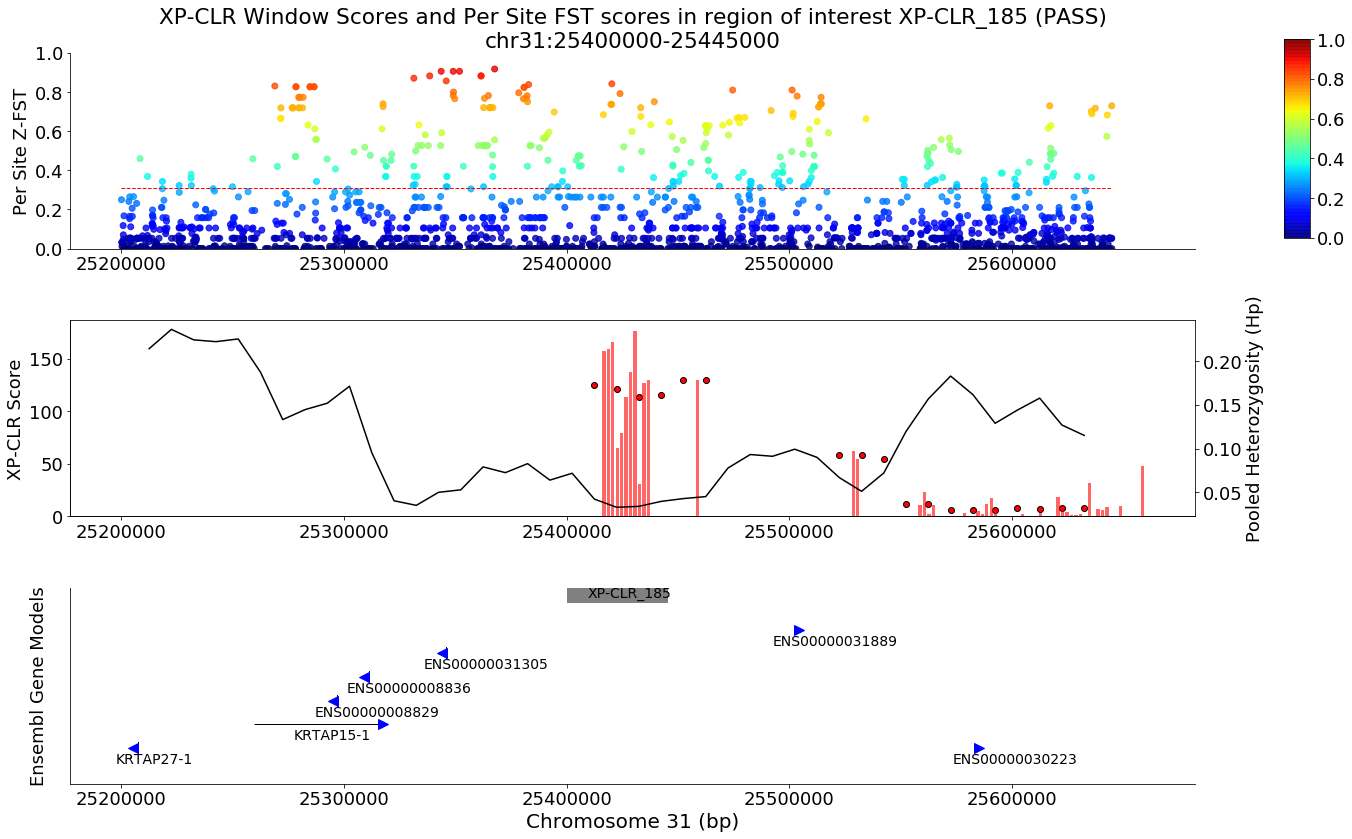

In [561]:
#Plotting individual merged, significant windows (with at least 3 windows)
for window in xpclrDict.keys():
    ROIchrom, ROIstart, ROIend, ROI_CDR = xpclrDict[window][0],int(xpclrDict[window][1]),int(xpclrDict[window][2]),xpclrDict[window][3]
    print('#%s' % ROI_CDR)
    coord = ROIchrom + ':' + str(ROIstart) + '-' + str(ROIend)
    ROIstart, ROIend = ROIstart - 200000, ROIend + 200000
    print ('Looking for the Fst information for these coordinates:',ROIchrom,ROIstart,ROIend)
    
    #Finding genes in the region
    genesOfInterest,genePos = find_gene_pos()

    print ('\nGenes of Interest in Region of Interest:\n', genesOfInterest)
    dataArray = get_xpclr_score(totalData,ROIchrom,ROIstart,ROIend)
    print('%i windows found within the region of interest (%s)' % (len(dataArray),ROI_CDR))
    perSiteZs =  get_per_site_zfst(perSiteDict)
    print('%i per site FST values in the region of interest (%s)' % (len(perSiteZs),ROI_CDR) )
    avgBars = get_slide_bars(slideData)
    print('%i sliding window average values in the region of interest (%s)'% (len(avgBars),ROI_CDR))
    hpX, hpY = get_hp_windows(realHpCoord,ROIchrom,ROIstart,ROIend)
    print('%i pooled heterozygosity windows in the region' % len(hpPlotList))
    
    #Draw per window plots
    plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/Campbell_No-MAF-Filter/50kbWindow_2kbGrid/Dogs_v_Wolves/SignificantWindows/plots/'
    plotFile = plotDir +'3Windows_50kbSpacing_'  + ROI_CDR + '_' + coord + '_50kbWindow_2kbGrid_25kbAverages_LocusPlot.png'
    passStatus = xpclrDict[window][11]
    draw_triple_plot(ROIchrom, ROI_CDR, dataArray, coord, plotFile, sigThreshold,passStatus)
    #break
print('DONE!')  

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


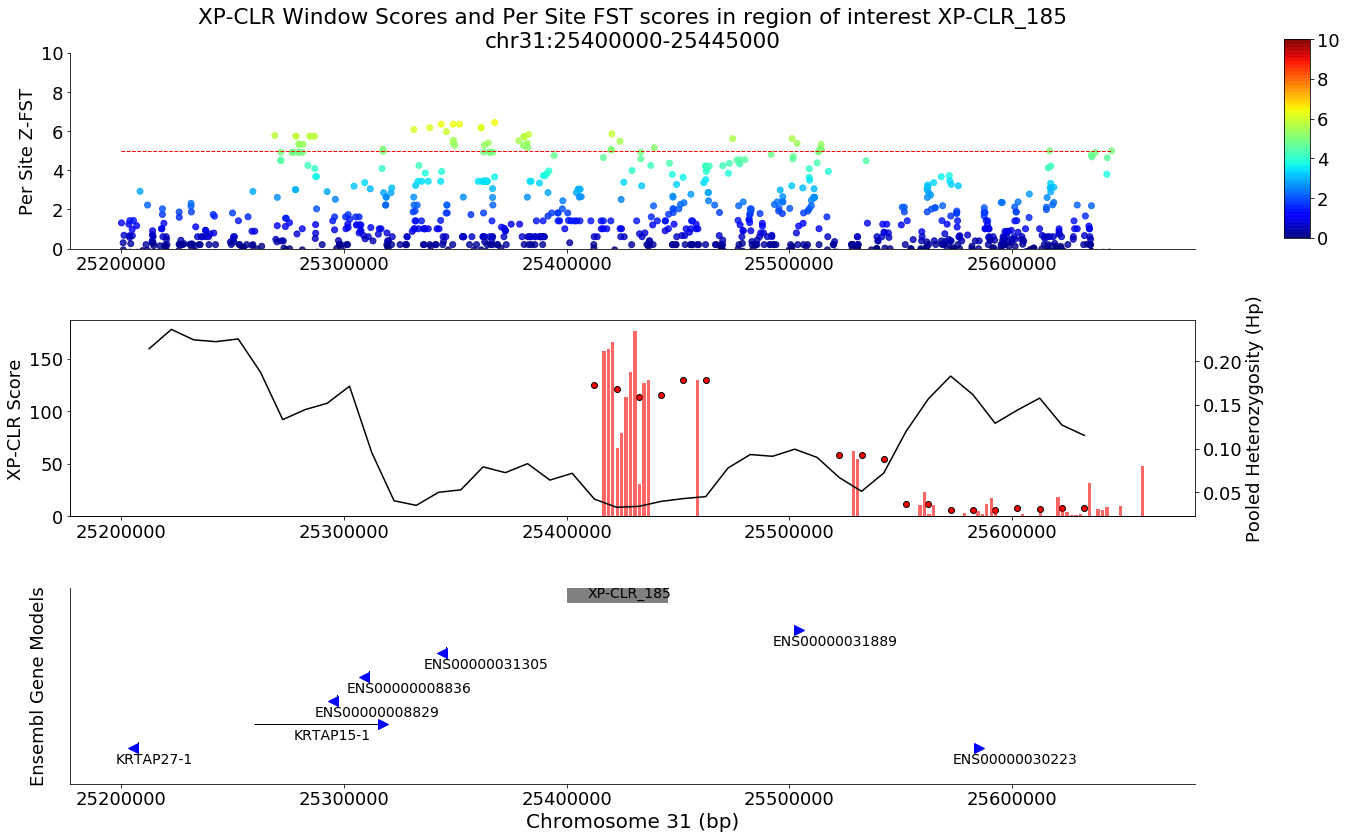

In [545]:
#Three subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True, figsize=(18,12))
########################################
####PLOT 1 - Per Site SNP Fst
x, y = [], []
for i in range(0,len(perSiteZs)):
    x.append(perSiteZs[i][1])
    y.append(perSiteZs[i][2])
colors=y
sc = axarr[0].scatter(x, y,c=colors, cmap=plt.cm.jet, vmin=0, vmax=10, alpha=0.8)
axarr[0].set_title('XP-CLR Window Scores and Per Site FST scores in region of interest %s\n%s' % (ROI_CDR,coord))
simpleaxis(axarr[0])
axarr[0].set_ylabel('Per Site Z-FST', fontsize =18)
axarr[0].hlines(y=5, xmin=np.min(x), xmax=np.max(x),lw=1,color="red",linestyles='dashed')
#y-axis
axarr[0].set_ylim(0,10)
#Add color bar
f.subplots_adjust(right=1.8)
cbar_ax = f.add_axes([1.0, 0.71, 0.02, 0.23])
f.colorbar(sc, cax=cbar_ax)
########################################
####PLOT 2- XP-CLR Scores
scoreList = []
for i in range(0,len(dataArray)):
    x, y, width = dataArray[i][1], dataArray[i][2], 1500
    scoreList.append(y)
    if y > sigThreshold:
        axarr[1].bar(x, y, width, color="red",linewidth=1,alpha=0.6)
        #axarr[1].scatter(x, y,color="red", alpha=0.8)
    else:
        #axarr[1].scatter(x, y,color="black", vmin=0, vmax=10, alpha=0.8)
        axarr[1].bar(x, y, width, color="black",fill=False,linewidth=1,alpha=0.6)
for j in range(0,len(avgBars)):
    start,end = avgBars[j][1],avgBars[j][2]
    midpoint = int((start + end)/2)
    x, y, width = midpoint, avgBars[j][3], 100000
    scoreList.append(y)
    if y > sigThreshold:
        axarr[1].scatter(x, y, color="red",facecolors='red', edgecolors='black')
    else:
        axarr[1].scatter(x, y, color="black",facecolors='none', edgecolors='black')

#PLOT HETEROZYGOSITY VALUES 
ax2 = axarr[1].twinx()
ax2.plot(hpX, hpY,color="black")
ax2.set_ylabel('Pooled Heterozygosity (Hp)', fontsize = 18)

simpleaxis(axarr[1])
axarr[1].set_ylabel('XP-CLR Score', fontsize=18)
axarr[1].set_ylim(0,np.max(scoreList)+10)
########################################
####PLOT 3 - GENE MODELS
#Add CDR  ROI window
CDR = [ROIstart+200000,ROIend-200000]
axarr[2].add_patch(patches.Rectangle((CDR[0], 9.4),(CDR[1]-CDR[0]),12,fill=True,color="grey"))
axarr[2].text(((ROIstart+ROIend)/2)-13000, 9.6,str(ROI_CDR),fontsize=14)

IDheights, geneheights, index, heights =[2.5,3.5,4.5,5.5,6.5,7.5], [3,4,5,6,7,8], -1, []
for gene in genesOfInterest:
    xRange = []
    #determines height to print the genes and gene IDs
    if index == 5:
        index = 0
    else:
        index += 1
    for i in range(0,len(genePos)):
        if gene == genePos[i][0]:
            x, direction, length = genePos[i][1], genePos[i][3], genePos[i][2]-genePos[i][1]
            axarr[2].add_patch(patches.Rectangle((x,geneheights[index]),length,0.5,facecolor="black"))
            xRange.append(x)
    xMin, xMax = min(xRange), max(xRange)
    if direction == '-':
        axarr[2].plot(xMin-2000, geneheights[index]+0.25, marker='<',color="blue",markersize=10)
    if direction == '+':
        axarr[2].plot(xMax+2000, geneheights[index]+0.25, marker='>',color="blue",markersize=10)
    axarr[2].hlines(y=geneheights[index]+0.25, xmin=xMin, xmax=xMax,lw=1,color="black")
    if 'ENSCAFG' in gene:#ADDING GENE TEXT
        gene = gene.replace('ENSCAFG','ENS')
    geneMidpoint = ((xMax+xMin)/2)-10000
    if geneMidpoint < ROIend-10000: #Make sure the gene ID doesn't get printed off the plot
        axarr[2].text(geneMidpoint,geneheights[index]-0.4,gene,fontsize=14)
    heights.append(geneheights[index])
axarr[2].axes.get_yaxis().set_ticks([])
axarr[2].set_ylim(+1.75,+10)
simpleaxis(axarr[2])
axarr[2].set_ylabel('Ensembl Gene Models', fontsize=18, labelpad=22)
axarr[2].set_xlabel('Chromosome %s (bp)' % (ROIchrom.replace('chr','')) , fontsize=20) #rotate yaxis label and move over from axis ticks
axarr[2].ticklabel_format(useOffset=False,style='plain',fontsize=18)#turn off sci-notation in  xaxis labelling

#Draw plot
f.tight_layout()

In [538]:
hpX

25632500